In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


In [2]:
df_train = pd.read_csv("dataset/train.csv")
df_test = pd.read_csv("dataset/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [3]:
display(df_train.describe())
display(df_test.describe())

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [4]:
display(df_train.head())
display(df_test.head())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
df_train.sample(5).text

394     Palestinian Teen Killed Amid Protests Against ...
4537    @RVacchianoNYDN The only surprise is that they...
1777    Sometimes in space celestial bodies with separ...
5804    The Ashes Test match is currently more interes...
4623    incident with injury:I-495  inner loop Exit 31...
Name: text, dtype: object

In [6]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
# Start with non-tensorflow approaches
# AUTO = tf.data.experimental.AUTOTUNE 

In [7]:
# Train, test, validation split
X = df_train["text"]
y = df_train["target"]

# If 42 is the answer, then 42*42 is the seed
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42*42)

X_test = df_test["text"] # Test data unknown

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Vectorize the training dataset text
# if it's fun to say, you know it's good
# tiffeediff
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', norm='l2')
X_train_vectorized = vectorizer.fit_transform(df_train['text'])

# Perform PCA analysis
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_vectorized.toarray())

# Print the explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)


Explained Variance Ratio: [0.00670651 0.00443326 0.0036723  0.00330665]


In [13]:
pca.explained_variance_ratio_.sum()

0.018118726638117085

C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


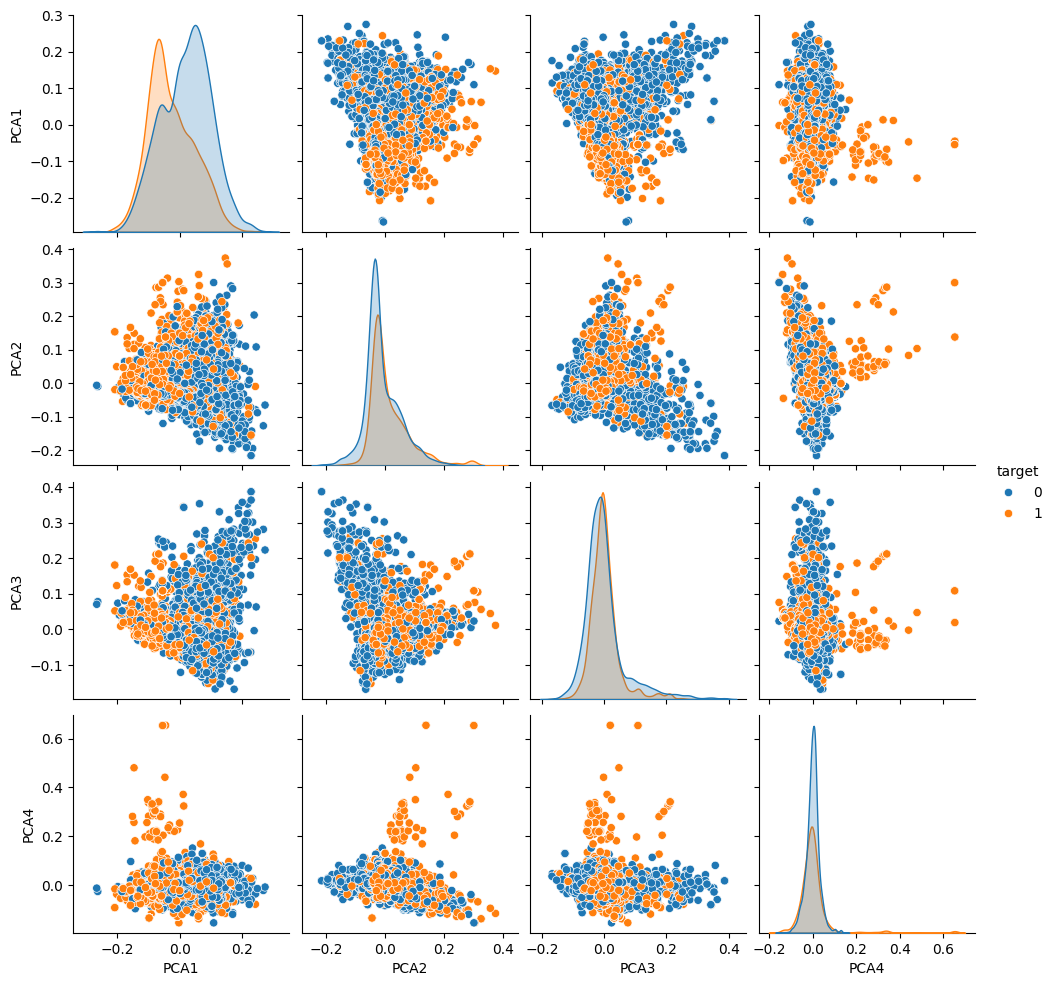

In [10]:
# Plot the PCA components in a seaborn pairplot
import seaborn as sns

# Create a dataframe from the PCA components
df_pca = pd.DataFrame(X_train_pca, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4'])
df_pca['target'] = df_train['target']

# Plot the pairplot
sns.pairplot(df_pca, hue='target')

In [20]:
# Find the words that are most correlated with the target variable

# Create a dataframe from the vectorized text
# sample = pd.DataFrame(X_train_vectorized.toarray()).sample(1000)
df_vectorized = pd.DataFrame(X_train_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
# df_vectorized['target'] = df_train['target']

df_vec_sample = df_vectorized.sample(5000)

# Calculate the correlation matrix
# correlation_matrix = df_vec_sample.corr()
correlation_series = df_vec_sample.corrwith(df_train['target'])

In [25]:
# Find the words that are most correlated with the target variable
# correlation_target = correlation_matrix['target']
# correlation_target = correlation_target.drop('target')
# correlation_target = correlation_target.sort_values(ascending=False).iloc[:10]

# # Print the most correlated words
# print(correlation_target)
correlation_series.sort_values(ascending=False).iloc[:25]

AttributeError: 'DataFrame' object has no attribute 'reshape'